PyTorchViz examples
==========

In [1]:
import torch
from torch import nn
from torchviz import make_dot, make_dot_from_trace

## Visualize gradients of simple MLP

The method below is for building directed graphs of PyTorch operations, built during forward propagation and showing which operations will be called on backward. It omits subgraphs which do not require gradients.

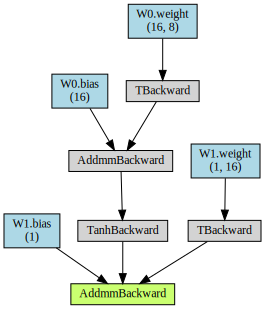

In [2]:
model = nn.Sequential()
model.add_module('W0', nn.Linear(8, 16))
model.add_module('tanh', nn.Tanh())
model.add_module('W1', nn.Linear(16, 1))

x = torch.randn(1,8)

make_dot(model(x), params=dict(model.named_parameters()))

### torch.jit.trace

An alternative to the above is `torch.jit.trace`, which gives more information about operations, and shows all operations performed during forward

In [3]:
with torch.onnx.set_training(model, False):
    trace, _ = torch.jit.get_trace_graph(model, args=(x,))
make_dot_from_trace(trace)

KeyError: 'input.1'

## Double Backpropagation

Implements "Double Backpropagation" from [Drucker and Lecun](http://yann.lecun.com/exdb/publis/pdf/drucker-lecun-92.pdf). The idea is to minimize the loss:

$$f(x, \theta) = f(x, \theta) + g(\frac{\partial f(x, \theta)}{\partial x})$$

where $x$ and $\theta$ are input and parameter vectors, $f(x, \theta)$ is the original loss function, and $g$ is a function of gradient w.r.t. input.

This is used in [Improved Wasserstein GAN](https://arxiv.org/abs/1704.00028) and [Attention Transfer](https://arxiv.org/abs/1612.03928).

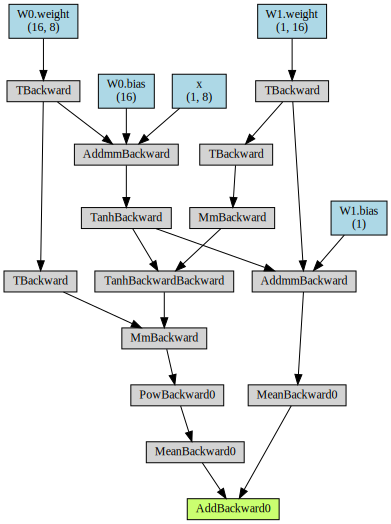

In [4]:
x = torch.randn(1,8).requires_grad_(True)

def double_backprop(inputs, net):
    y = net(x).mean()
    grad,  = torch.autograd.grad(y, x, create_graph=True, retain_graph=True)
    return grad.pow(2).mean() + y

make_dot(double_backprop(x, model), params=dict(list(model.named_parameters()) + [('x', x)]))

## AlexNet

In [6]:
from torchvision.models import AlexNet

model = AlexNet()

x = torch.randn(1, 3, 227, 227).requires_grad_(True)
y = model(x)
make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)])).save

<bound method File.save of <graphviz.dot.Digraph object at 0x7f1c303c6048>>

In [7]:
with torch.onnx.set_training(model, False):
    trace, _ = torch.jit.get_trace_graph(model, args=(x,))
make_dot_from_trace(trace)

AssertionError: %35 : Tensor = onnx::Unsqueeze[axes=[0]](%33)
 has empty scope name

And AlexNet double backprop for fun:

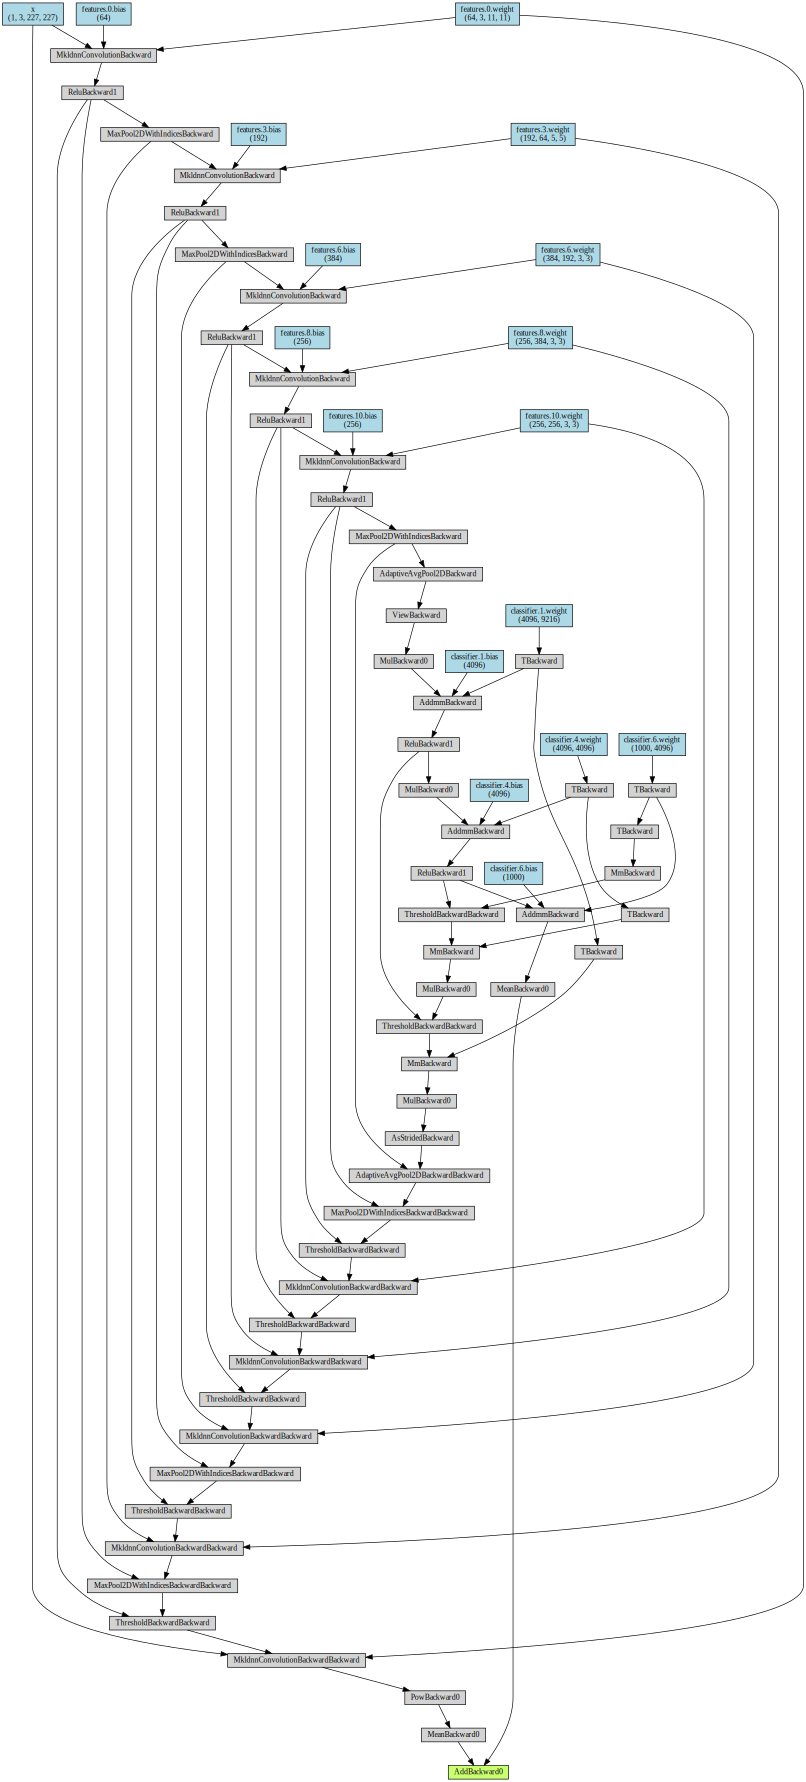

In [8]:
make_dot(double_backprop(x, model), params=dict(list(model.named_parameters()) + [('x', x)]))

## LSTM cell

In [11]:
lstm_cell = nn.LSTMCell(128, 128)
x = torch.randn(1, 128)
make_dot(lstm_cell(x), params=dict(list(lstm_cell.named_parameters()))).render('output-graph.gv', view=True)

'output-graph.gv.pdf'

In [10]:
dot.format = 'png'
dot.render('output-graph.gv', view=True)

NameError: name 'dot' is not defined

In [12]:
import torch
from torchviz import make_dot
from torch.autograd import Variable
from torchsummary import summary

netG = torch.load('5_net_G.pth')  # 直接打印
summary(netG, (3,256,256))  # 每层输出shape
xtmp = Variable(torch.randn(1,3,256,256))
ytmp = netG(xtmp)
make_dot(ytmp, params=dict(netG.named_parameters())).render('tmp', view=True)  # render用于保存为图片

AttributeError: 'collections.OrderedDict' object has no attribute 'apply'

In [2]:
netG

OrderedDict([('model.model.0.weight',
              tensor([[[[ 8.2023e-03,  3.6769e-02,  1.7465e-03, -1.3720e-02],
                        [ 1.7380e-02,  1.0171e-02, -4.9724e-02,  6.2419e-03],
                        [-7.3697e-03, -1.5335e-02,  1.1779e-02,  2.1102e-02],
                        [-4.1504e-02,  2.4184e-02, -2.0440e-02,  1.8614e-02]],
              
                       [[-2.1184e-04,  3.1667e-02, -1.2896e-03, -1.6541e-02],
                        [-4.9755e-02,  1.4027e-02,  9.6713e-03,  6.4590e-03],
                        [ 3.2227e-03,  1.7634e-03,  2.9306e-02,  2.1867e-02],
                        [-8.2030e-03,  2.6780e-02,  4.5341e-02,  1.2020e-02]],
              
                       [[-1.3270e-03, -3.5131e-02,  1.2950e-02,  9.9111e-03],
                        [-1.1800e-02, -2.0816e-02,  1.9365e-02, -2.2126e-02],
                        [ 2.3350e-02,  5.3692e-03,  3.1979e-02, -5.3716e-03],
                        [ 3.2117e-02,  5.0357e-02, -2.6473e-02, -4.3005e